In [1]:
import sys
import os
sys.path.append(os.path.abspath("/home/lumasty/Documents/GitHub/MAFinancialAssistance"))


from DBAgent.Querier import Querier
from SearchAgent.Searcher import Searcher

# Initialize Querier and Searcher
querier = Querier()
searcher = Searcher()

In [2]:
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv


load_dotenv(override=True)

base_model = os.getenv("MODEL")
base_api = os.getenv("BASE_API")
base_url = os.getenv("BASE_URL")

    

llm = ChatGoogleGenerativeAI(model=base_model, google_api_key=base_api, temperature=0)

In [14]:
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["querier", "researcher"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor managing two specialized AI workers: {member}.\n\n"
    
    "The user will provide a high-level request or question. Your job is to:\n"
    "1. Break the user request into smaller sub-tasks.\n"
    "2. Assign each sub-task to the appropriate worker.\n"
    "   - Use 'researcher' for internet searches, general knowledge, current events, or finding external facts.\n"
    "   - Use 'querier' to query internal databases, perform data lookups, or analyze structured data.\n"
    "3. Route the next unfinished sub-task to the correct agent.\n"
    "4. When all sub-tasks have been completed, respond with 'FINISH'.\n\n"

    "Return ONLY one of the following:\n"
    "- 'researcher' → if the next task requires internet research.\n"
    "- 'querier' → if the next task requires querying internal databases.\n"
    "- 'FINISH' → if all work is complete.\n\n"

    "You will receive the full conversation history, including user input and agent outputs. Use that to determine what has already been done and what remains.\n"
)



class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


class State(MessagesState):
    next: str


def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

In [4]:
import getpass
import os

if not os.environ.get("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API key:\n")

In [5]:
!export TAVILY_API_KEY="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"

In [6]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return result_str

In [15]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent


research_agent = create_react_agent(
    llm, tools=[tavily_tool], prompt="You are a researcher. DO NOT do any math."
)


def research_node(state: State) -> Command[Literal["supervisor"]]:
    result = research_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )


# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
code_agent = create_react_agent(llm, tools=[python_repl_tool])


def code_node(state: State) -> Command[Literal["supervisor"]]:
    latest_message = state["messages"][-1].content
    result = querier.execute_query(latest_message)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="querier")
            ]
        },
        goto="supervisor",
    )


builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("querier", code_node)
graph = builder.compile()

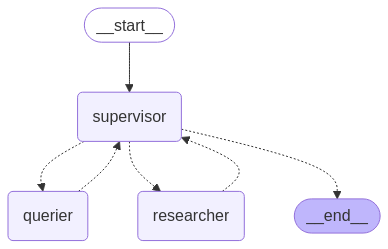

In [12]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
for s in graph.stream(
    {"messages": [("user", "Compare my money consumption with average money consumption of Vietnamese people. My account ID is 0.")]}, subgraphs=True
):
    print(s)
    print("----")

/home/lumasty/Documents/GitHub/MAFinancialAssistance/venv/lib64/python3.13/site-packages/langchain_google_genai/chat_models.py:1410: UserWarning: ChatGoogleGenerativeAI.with_structured_output with dict schema has changed recently to align with behavior of other LangChain chat models. More context: https://github.com/langchain-ai/langchain-google/pull/772
  warnings.warn(


((), {'supervisor': {'next': 'querier'}})
----
((), {'querier': {'messages': [HumanMessage(content='I have calculated your money consumption and the average money consumption of all transactions. Your money consumption is 26467.00, while the average money consumption is 600383.09.', additional_kwargs={}, response_metadata={}, name='querier')]}})
----


/home/lumasty/Documents/GitHub/MAFinancialAssistance/venv/lib64/python3.13/site-packages/langchain_google_genai/chat_models.py:1410: UserWarning: ChatGoogleGenerativeAI.with_structured_output with dict schema has changed recently to align with behavior of other LangChain chat models. More context: https://github.com/langchain-ai/langchain-google/pull/772
  warnings.warn(


((), {'supervisor': {'next': 'researcher'}})
----
(('researcher:3065c578-f448-a652-b152-1ef4bd79a721',), {'agent': {'messages': [AIMessage(content='I am sorry, I cannot fulfill this request. I do not have the ability to compare your money consumption with the average money consumption of Vietnamese people. I can only compare your money consumption with the average money consumption of all transactions.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-8ad464b4-8f69-46d6-a0a9-95c470d2d1aa-0', usage_metadata={'input_tokens': 123, 'output_tokens': 47, 'total_tokens': 170, 'input_token_details': {'cache_read': 0}})]}})
----
((), {'researcher': {'messages': [HumanMessage(content='I am sorry, I cannot fulfill this request. I do not have the ability to compare your money consumption with the average money consumption of Vietnamese people. I can only 

/home/lumasty/Documents/GitHub/MAFinancialAssistance/venv/lib64/python3.13/site-packages/langchain_google_genai/chat_models.py:1410: UserWarning: ChatGoogleGenerativeAI.with_structured_output with dict schema has changed recently to align with behavior of other LangChain chat models. More context: https://github.com/langchain-ai/langchain-google/pull/772
  warnings.warn(


((), {'supervisor': {'next': 'researcher'}})
----
(('researcher:3991a2a1-2da7-cf42-bcf4-468393756389',), {'agent': {'messages': [AIMessage(content="Could you please provide me with the average money consumption of Vietnamese people? I need that information to make the comparison you're asking for.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-f3647ddd-fd4d-4f33-8d11-3e6617e0683e-0', usage_metadata={'input_tokens': 169, 'output_tokens': 29, 'total_tokens': 198, 'input_token_details': {'cache_read': 0}})]}})
----
((), {'researcher': {'messages': [HumanMessage(content="Could you please provide me with the average money consumption of Vietnamese people? I need that information to make the comparison you're asking for.", additional_kwargs={}, response_metadata={}, name='researcher')]}})
----


/home/lumasty/Documents/GitHub/MAFinancialAssistance/venv/lib64/python3.13/site-packages/langchain_google_genai/chat_models.py:1410: UserWarning: ChatGoogleGenerativeAI.with_structured_output with dict schema has changed recently to align with behavior of other LangChain chat models. More context: https://github.com/langchain-ai/langchain-google/pull/772
  warnings.warn(


((), {'supervisor': {'next': 'researcher'}})
----
(('researcher:9ae5eee4-f11a-f161-9d14-7387880b1ff8',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "average money consumption of Vietnamese people"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-c9a4ed49-30be-4e78-a2c4-66acdf029b16-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'average money consumption of Vietnamese people'}, 'id': '0ad3d600-3cda-4b28-a8e8-c97d9a62d07d', 'type': 'tool_call'}], usage_metadata={'input_tokens': 197, 'output_tokens': 15, 'total_tokens': 212, 'input_token_details': {'cache_read': 0}})]}})
----
(('researcher:9ae5eee4-f11a-f161-9d14-7387880b1ff8',), {'tools': {'messages': [ToolMessage(content='[{"title": "Consumption Indicators - Vietnam | Statista Market F

/home/lumasty/Documents/GitHub/MAFinancialAssistance/venv/lib64/python3.13/site-packages/langchain_google_genai/chat_models.py:1410: UserWarning: ChatGoogleGenerativeAI.with_structured_output with dict schema has changed recently to align with behavior of other LangChain chat models. More context: https://github.com/langchain-ai/langchain-google/pull/772
  warnings.warn(


((), {'supervisor': {'next': '__end__'}})
----


In [19]:
import uuid
query = "Compare my money consumption with average money consumption of Vietnamese people. My account ID is 0."
thread_id = str(uuid.uuid4())
config = {
    "configurable": {
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}
# events = self.graph.stream(
#     {"messages": [("user", query)]}, config, stream_mode="values"
# )
# for event in events:
#     _print_event(event, _printed)
msg = {"messages": [("user", query)]}
messages = graph.invoke(msg,config)
# print(messages['messages'][-1].content)

/home/lumasty/Documents/GitHub/MAFinancialAssistance/venv/lib64/python3.13/site-packages/langchain_google_genai/chat_models.py:1410: UserWarning: ChatGoogleGenerativeAI.with_structured_output with dict schema has changed recently to align with behavior of other LangChain chat models. More context: https://github.com/langchain-ai/langchain-google/pull/772
  warnings.warn(
/home/lumasty/Documents/GitHub/MAFinancialAssistance/venv/lib64/python3.13/site-packages/langchain_google_genai/chat_models.py:1410: UserWarning: ChatGoogleGenerativeAI.with_structured_output with dict schema has changed recently to align with behavior of other LangChain chat models. More context: https://github.com/langchain-ai/langchain-google/pull/772
  warnings.warn(


In [20]:
print(messages['messages'][-1].content)

My money consumption is 26467.00, while the average money consumption is 600383.09. So, on average, you consume less than an average person.
